In [1]:

# imports

#%matplotlib widget
import matplotlib.pyplot as plt

import datetime as dt
import pandas as pd
from seismostats import plot_in_space, bin_to_precision
import numpy as np
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from tqdm import tqdm
import itertools


from functions.general_functions import inverse_norm
from functions.transformation_functions import transform_and_rotate, cut_section
from functions.d_dimensional import mac_d_dimensions, plot_averagemap, plot_voronoi_map

%config InlineBackend.figure_format ='retina'
%matplotlib inline

# 1: Get data and change format

In [2]:
df_raw = pd.read_csv('data/parkfield_data_1984_2024_NEW.csv')

In [3]:
# empty dataframe
df = pd.DataFrame()
# mags
df['magnitude'] = df_raw['Mag']
# lon
df['longitude'] = df_raw['Lon']
# lat
df['latitude'] = df_raw['Lat']
# depth
df['depth'] = df_raw['Depth']
# time
df['time'] = pd.to_datetime(df_raw['Date'] + ' ' + df_raw['Time'])

df['Magt'] = df_raw['Magt']

/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_40527/2914756864.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time'] = pd.to_datetime(df_raw['Date'] + ' ' + df_raw['Time'])


# 2: Plot on map

[8. 8.]
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>


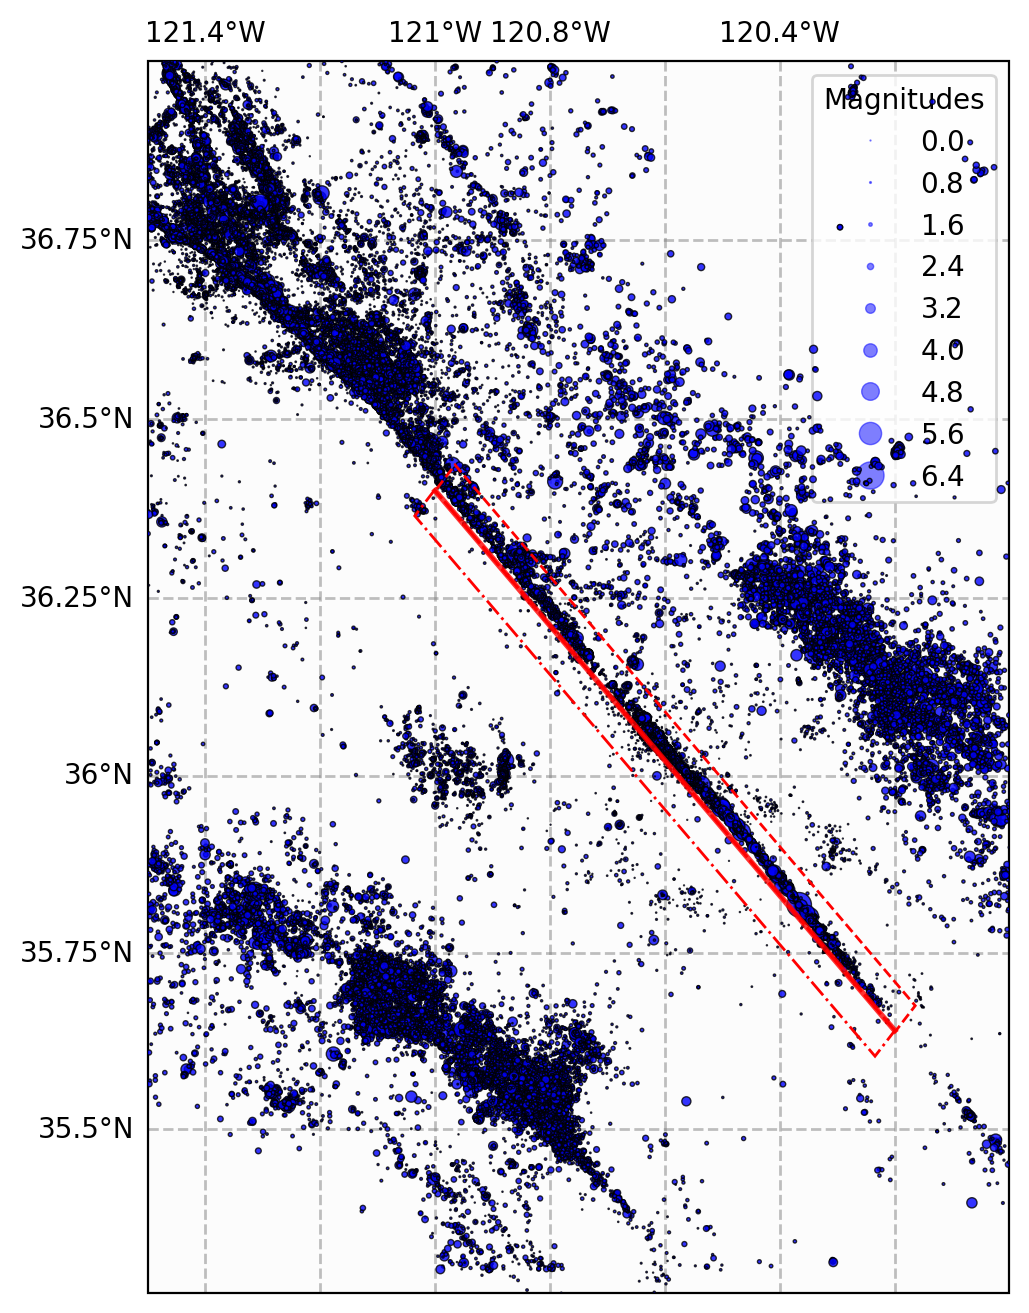

In [4]:
fig = plt.figure(figsize=(8, 8), linewidth=1)    
ax = plot_in_space(df, dot_smallest=0.1,dot_largest=100,dot_interpolation_power=3, include_map=True)

# plot a red line from $P_1 = 121W, 35.64^N) and $P_2 = 120.2W, 36.4N
ll_proj = ccrs.PlateCarree()  # CRS for raw long/lat
exts = [
        min(df["longitude"]),
        max(df["longitude"]),
        min(df["latitude"]),
        max(df["latitude"]),
]
ax.set_extent(exts, crs=ll_proj)


ax.plot([-120.2, -121], [35.64, 36.4],
        color="red",
        zorder=1000,
        transform=ccrs.PlateCarree(),
        linewidth=2,
        alpha=0.8,
    )

# Define the two points
lon1, lat1 = -120.2, 35.64  # point 1
lon2, lat2 = -121, 36.4  # point 2

# Calculate the angle between the two points
angle = np.degrees(np.arctan2(lat2 - lat1, lon2 - lon1))

# Define the width of the box
llll = 1.105
wwww = 0.05

# Create a rectangle
rectangle = mpatches.Rectangle((lon1, lat1), llll, wwww, angle=angle, fill=None, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), linestyle='-.',lw=1, zorder=1000)
# Add the rectangle to the plot
ax.add_patch(rectangle)

rectangle = mpatches.Rectangle((lon2, lat2), llll, wwww, angle=180+angle, fill=None,edgecolor='red', linewidth=2, transform=ccrs.PlateCarree(), linestyle='--',lw=1, zorder=1000)
# Add the rectangle to the plot
ax.add_patch(rectangle)

# get current figure
fig = plt.gcf()
print(fig.get_size_inches())  # Print the size of the figure

# 3: cut out Parkfield section

In [5]:
# cross-section
p1 = np.array([36.40, -121.00, 0]) # point where cross-cut begins
p2 = np.array([35.64,-120.20, 0]) # point where cross-cut ends
depth = 20  # in km
width = 10  # width of the section in km
delta = 1   # resolution of grid that is plotted on


In [6]:
x_vor=[];
y_vor=[];
z_vor=[];

mags = np.array(df['magnitude'])

# bin mags
delta_m = 0.01
mags = bin_to_precision(mags, delta_m)

lats = np.array(df['latitude'])
lons = np.array(df['longitude'])
depths = np.array(df['depth'])
time = np.array(df['time'])

#transform to cartesian coordinates, to that p1 is on origin, p2 is on y
# axis and the fault plane is the x-z plane
cart_coords, cart_p2 = transform_and_rotate(p1, p2, lats, lons, depths)

# cut data to only the one in the section
length = np.linalg.norm(cart_p2)
cut_coords, idx1 = cut_section(cart_coords, length, width, depth)
cut_mags = mags[idx1]
cut_times = time[idx1]
cut_depths = depths[idx1]

# oder data in time
idx2 = np.argsort(cut_times)
cut_mags = cut_mags[idx2]
cut_times = cut_times[idx2]
cut_depths = cut_depths[idx2]
cut_coords =cut_coords[:,idx2]

depth 20 -18.450850476287314


# 4: Cut out magnitudes below completeness

In [7]:
mc = 1.3
idx = cut_mags >= mc

cut_mags = cut_mags[idx]
cut_times = cut_times[idx]
cut_depths = cut_depths[idx]
cut_coords = cut_coords[:,idx]

delta_m = 0.01
cut_mags = bin_to_precision(cut_mags, delta_m)


df_PF = pd.DataFrame()
df_PF['magnitude'] = cut_mags
df_PF['time'] = cut_times
df_PF['depth'] = cut_depths
df_PF['x'] = cut_coords[0]
df_PF['y'] = cut_coords[1]
df_PF['z'] = cut_coords[2]

# 5: Estimate the 1D MAC and plot

In [8]:
from functions.one_dimensional import mac_one_dimension

In [9]:
time_delta = (max(cut_times)- min(cut_times))
years = time_delta / np.timedelta64(1, 'D') / 365.25
n_points=  100

mac, mu_mac, std_mac, b_right, std_b_right = mac_one_dimension(cut_times, cut_mags, delta_m, mc, cut_times, n_points=n_points, n_realizations=1000, b_method='tinti', partitioning='constant_idx', image_tech='right', scaling_factor=years)

mac, mu_mac, std_mac, b_center, std_b_center = mac_one_dimension(cut_times, cut_mags, delta_m, mc, cut_times, n_points=n_points, n_realizations=400, b_method='tinti', partitioning='constant_idx', image_tech='center', scaling_factor=years)

mac, mu_mac, std_mac, b_average, std_b_averaga = mac_one_dimension(cut_times, cut_mags, delta_m, mc, cut_times, n_points=n_points, n_realizations=400, b_method='tinti', partitioning='random_idx', image_tech='average', scaling_factor=years)

/Users/aron/polybox/Projects/statistical_seismology2024/functions/one_dimensional.py:129: UserWarning: The number of realizations was too large, leadingto repititions. Therefore it was reduced.
  warnings.warn("The number of realizations was too large, leading"
/Users/aron/polybox/Projects/statistical_seismology2024/env/lib/python3.12/site-packages/seismostats/analysis/estimate_beta.py:96: UserWarning: no magnitudes in the lowest magnitude bin are present.check if mc is chosen correctly
  warnings.warn(
/Users/aron/polybox/Projects/statistical_seismology2024/functions/one_dimensional.py:237: RuntimeWarning: invalid value encountered in divide
  b_average = b_average / average_cnt_b
/Users/aron/polybox/Projects/statistical_seismology2024/functions/one_dimensional.py:238: RuntimeWarning: invalid value encountered in divide
  std_b_average = std_b_average / average_cnt_b


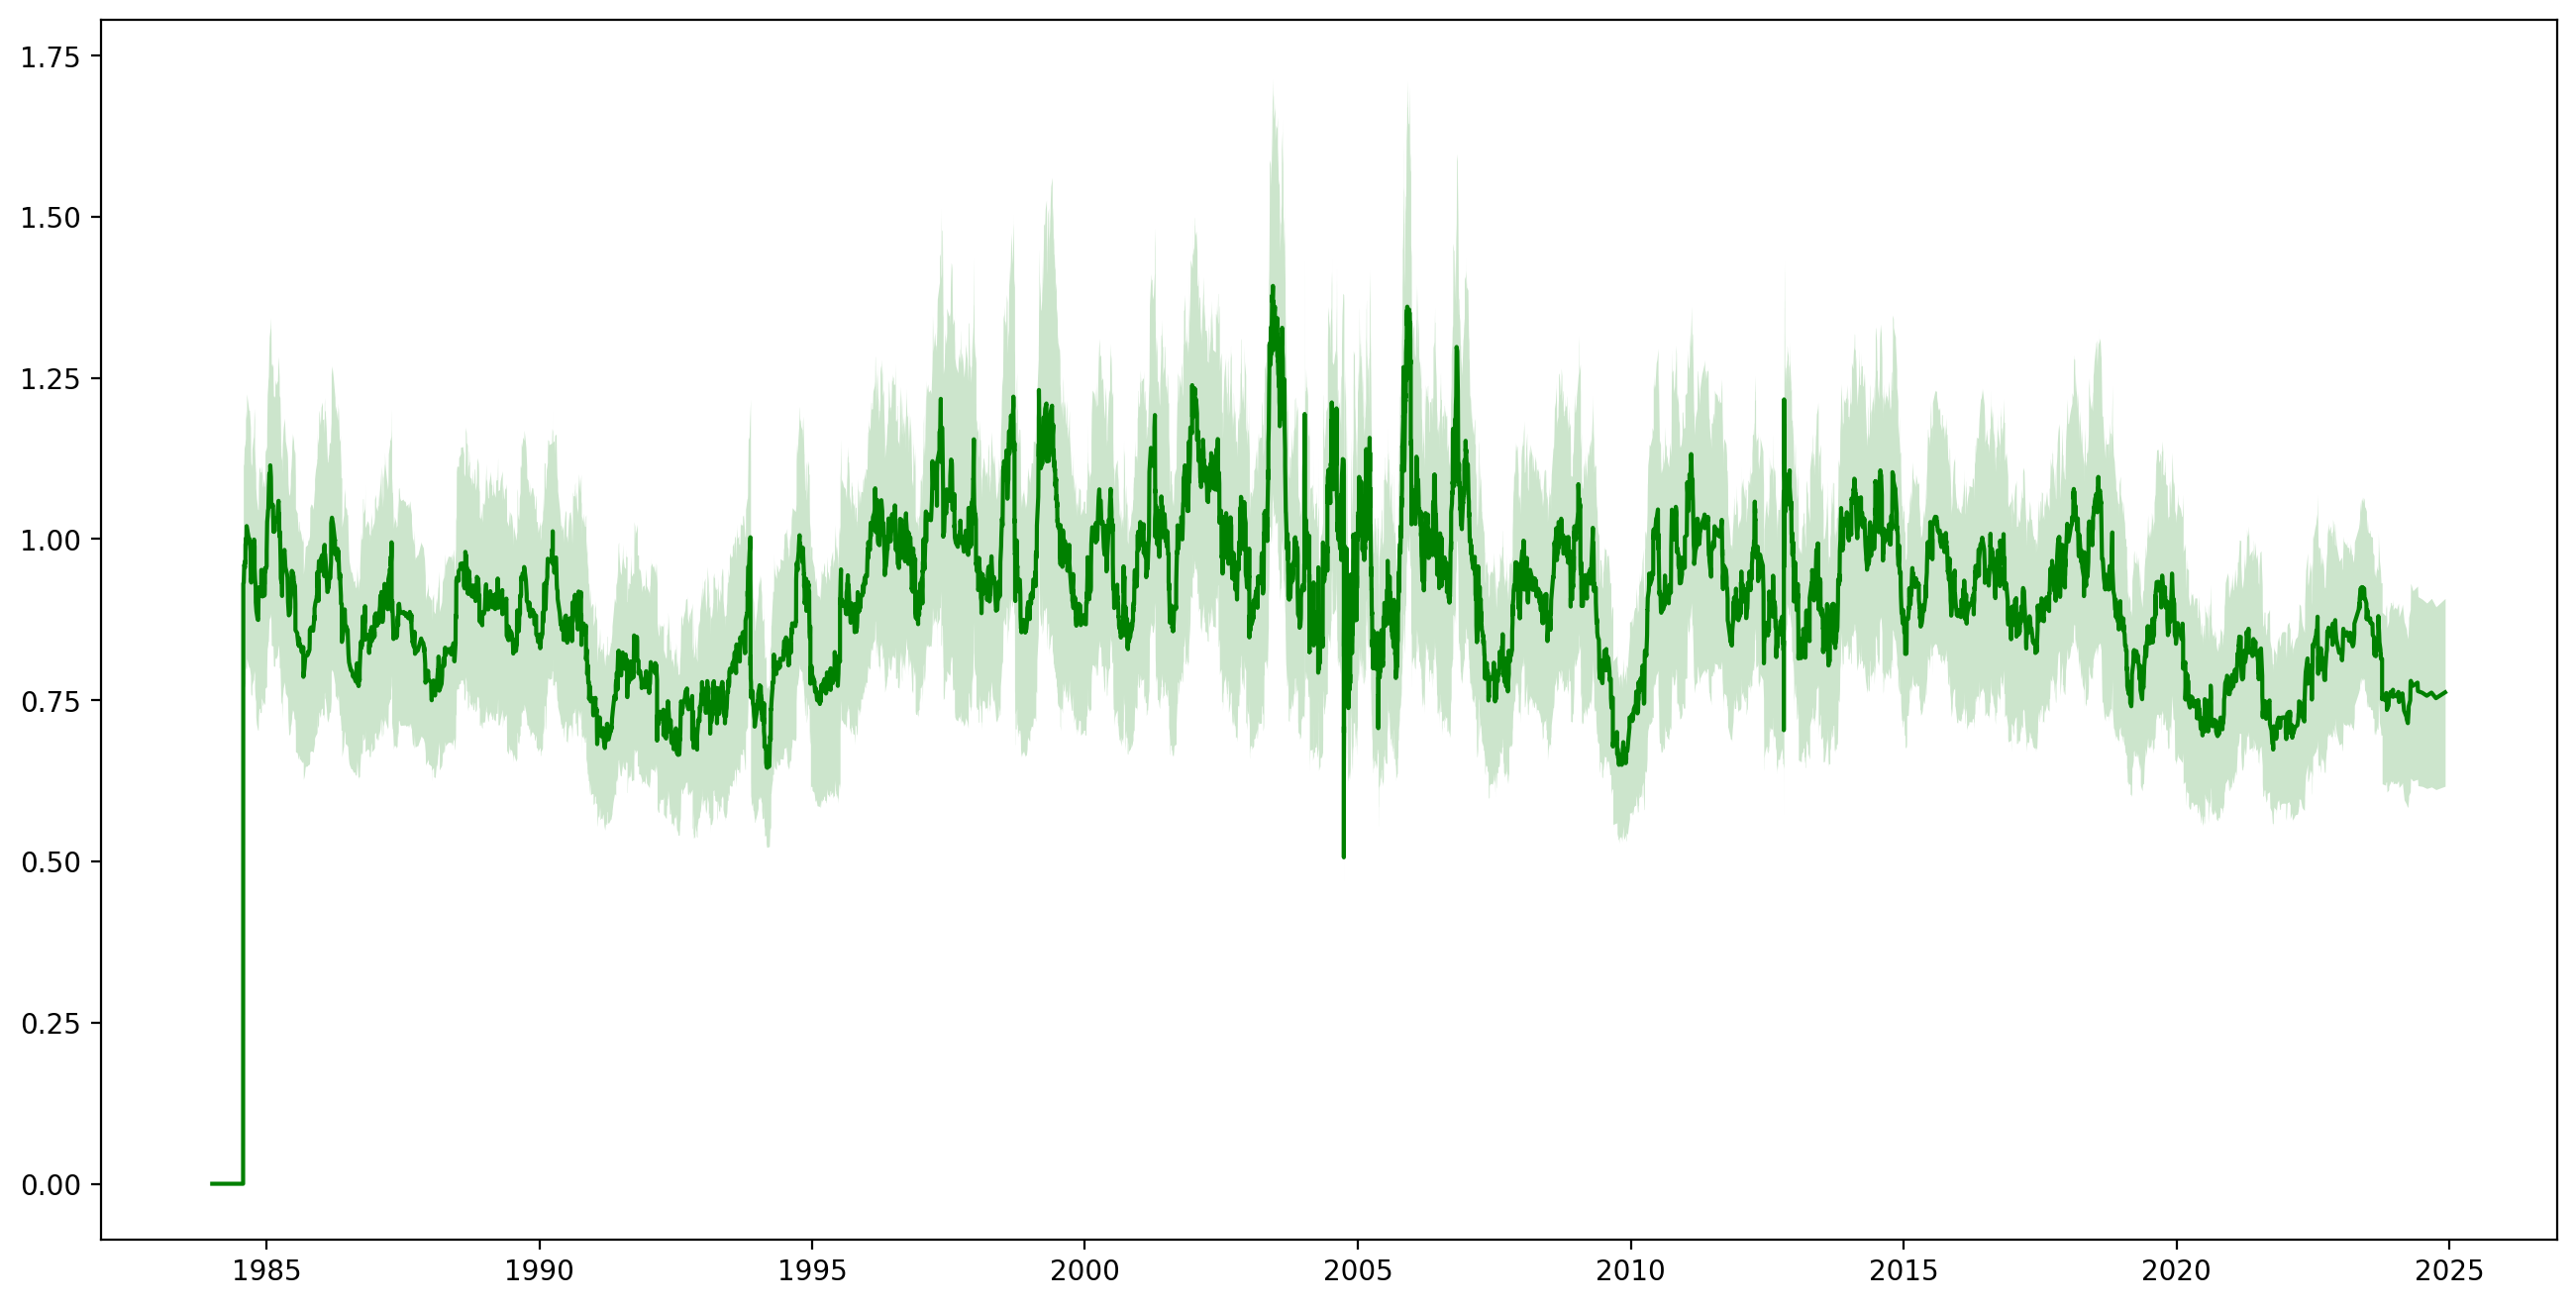

In [38]:
fig, ax = plt.subplots(figsize=(16, 8))

plt.plot(cut_times, b_right, c='g')
plt.fill_between(cut_times, b_right-2*std_b_right, b_right+2*std_b_right, color='g', alpha=0.2, lw=0)   

# plot m6 event
date = np.datetime64(dt.datetime(2004, 9, 28))
idx = cut_times == date

In [17]:
def get_MAC_vs_npoints_1D(
      order,
      cut_mags,
      delta_m,
      mc,
      cut_times,
      n_points,
      n=200,
      b_method="positive",
      partitioning = 'constant_idx',
      image_tech = 'right',
      scaling_factor=1):

      idx_order = np.argsort(order)
      order = order[idx_order]
      cut_mags = cut_mags[idx_order]
      cut_times = cut_times[idx_order]

      # estimate MAC for different number of points
      mac = np.zeros(len(n_points))
      mu_mac = np.zeros(len(n_points))
      std_mac = np.zeros(len(n_points))
      b_average= []
      std_b =[]
      mac_a = np.zeros(len(n_points))
      mu_mac_a = np.zeros(len(n_points))
      std_mac_a = np.zeros(len(n_points))
      n_m = np.zeros(len(n_points))
      a_average = []
      for ii, n_point in enumerate(tqdm(n_points, desc="Processing")):
         (mac[ii], mu_mac[ii], std_mac[ii], b_average_loop, std_b_loop, mac_a[ii], 
          mu_mac_a[ii], std_mac_a[ii], a_average_loop, n_m[ii]
          ) = mac_one_dimension(order, cut_mags, delta_m, mc, cut_times, n_points=n_point, n_realizations=n, b_method=b_method, partitioning=partitioning, image_tech=image_tech, scaling_factor=scaling_factor, return_nm=True, include_a=True)
         b_average.append(b_average_loop)
         std_b.append(std_b_loop)
         a_average.append(a_average_loop)

      return mac, mu_mac, std_mac, b_average, std_b, mac_a, mu_mac_a, std_mac_a, a_average, n_m

In [18]:
n_m = np.array(np.arange(40, 400, 15))
n_points = np.round(len(cut_mags)/ n_m)
n_points = np.unique(n_points).astype(int)

mac, mu_mac, std_mac, b_average, std_b, mac_a, mu_mac_a, std_mac_a, a_average, n_m = get_MAC_vs_npoints_1D(cut_coords[2,:], cut_mags, delta_m, mc, cut_times, n_points, n=1000, b_method = 'positive', partitioning = 'constant_idx',
scaling_factor=max(cut_depths)-min(cut_depths), image_tech='center')

Processing:   0%|          | 0/24 [00:00<?, ?it/s]/Users/aron/polybox/Projects/statistical_seismology2024/functions/one_dimensional.py:129: UserWarning: The number of realizations was too large, leadingto repititions. Therefore it was reduced.
  warnings.warn("The number of realizations was too large, leading"
Processing: 100%|██████████| 24/24 [00:30<00:00,  1.28s/it]


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_40527/1358466162.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(n_m, mu_mac, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


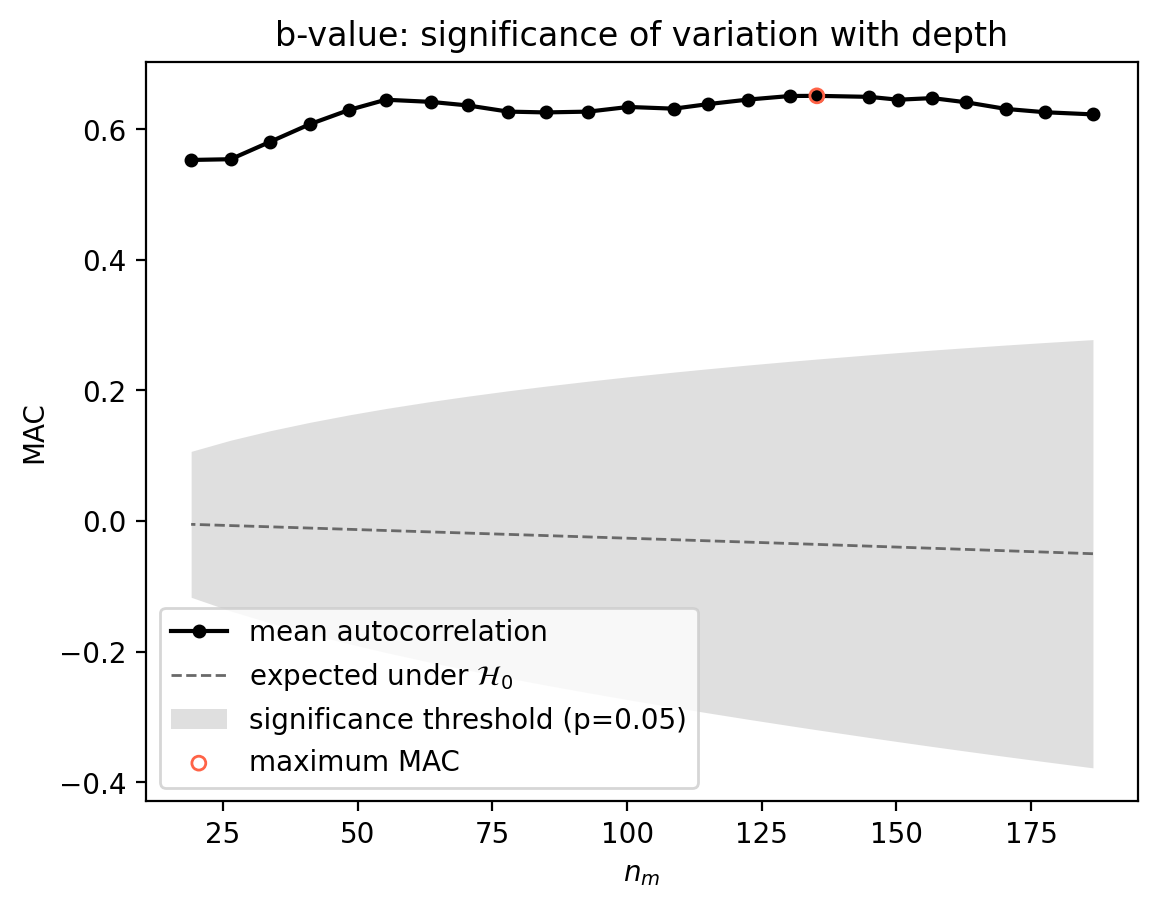

In [19]:
ax = plt.subplots()[1]

ax.plot(n_m, mac, color='k', label='mean autocorrelation', marker='o', markersize=4)    
ax.plot(n_m, mu_mac, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
ax.fill_between(n_m, mu_mac - 1.96 * std_mac, mu_mac + 1.96 * std_mac, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

n_max = np.argmax(mac)
plt.scatter(n_m[n_max], mac[n_max], s=25, zorder=100, facecolor='none', edgecolor='tomato', label='maximum MAC')

ax.legend()
ax.set_xlabel('$n_m$')
ax.set_ylabel('MAC')
ax.title.set_text('b-value: significance of variation with depth')

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_40527/105027914.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(n_m, mu_mac_a, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


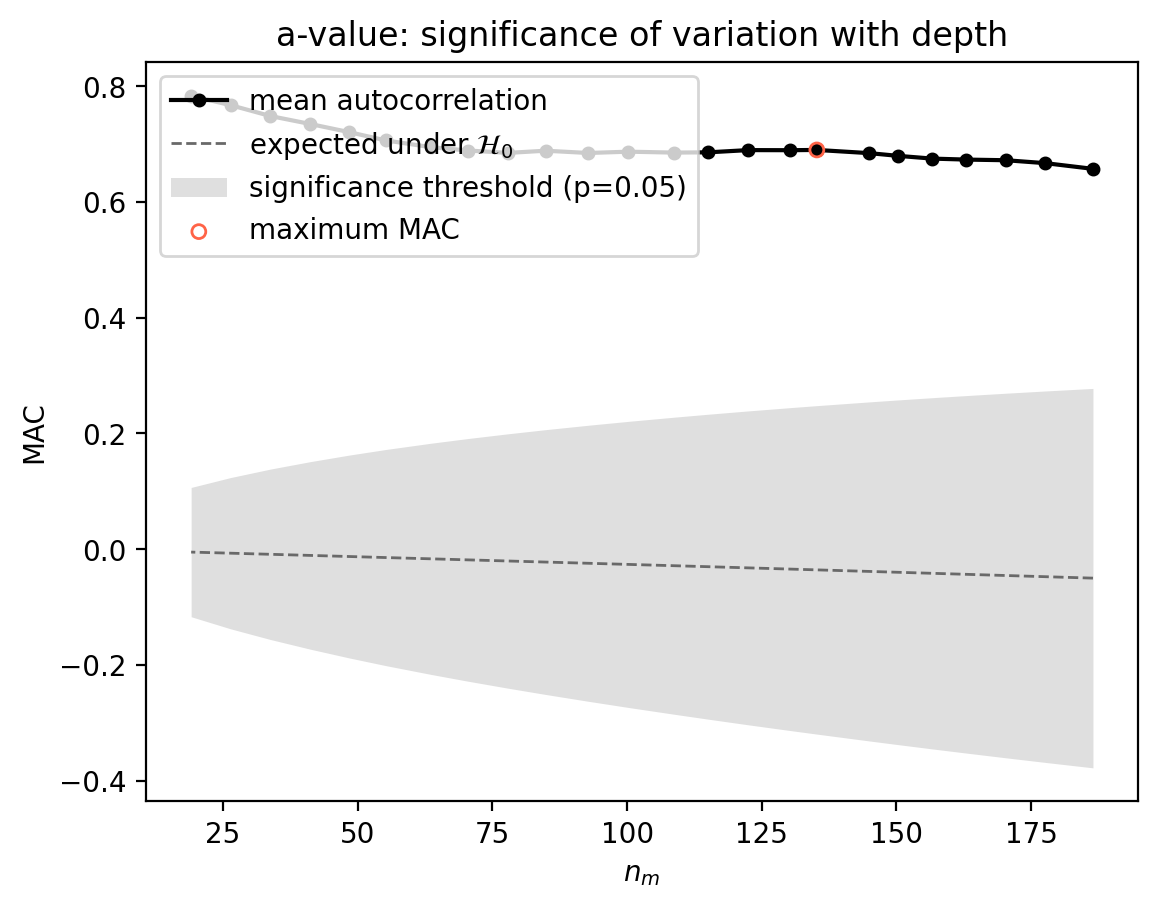

In [20]:
ax = plt.subplots()[1]

ax.plot(n_m, mac_a, color='k', label='mean autocorrelation', marker='o', markersize=4)    
ax.plot(n_m, mu_mac_a, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
ax.fill_between(n_m, mu_mac_a - 1.96 * std_mac_a, mu_mac_a + 1.96 * std_mac_a, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

plt.scatter(n_m[n_max], mac_a[n_max], s=25, zorder=100, facecolor='none', edgecolor='tomato', label='maximum MAC')

ax.legend()
ax.set_xlabel('$n_m$')
ax.set_ylabel('MAC')
ax.title.set_text('a-value: significance of variation with depth')

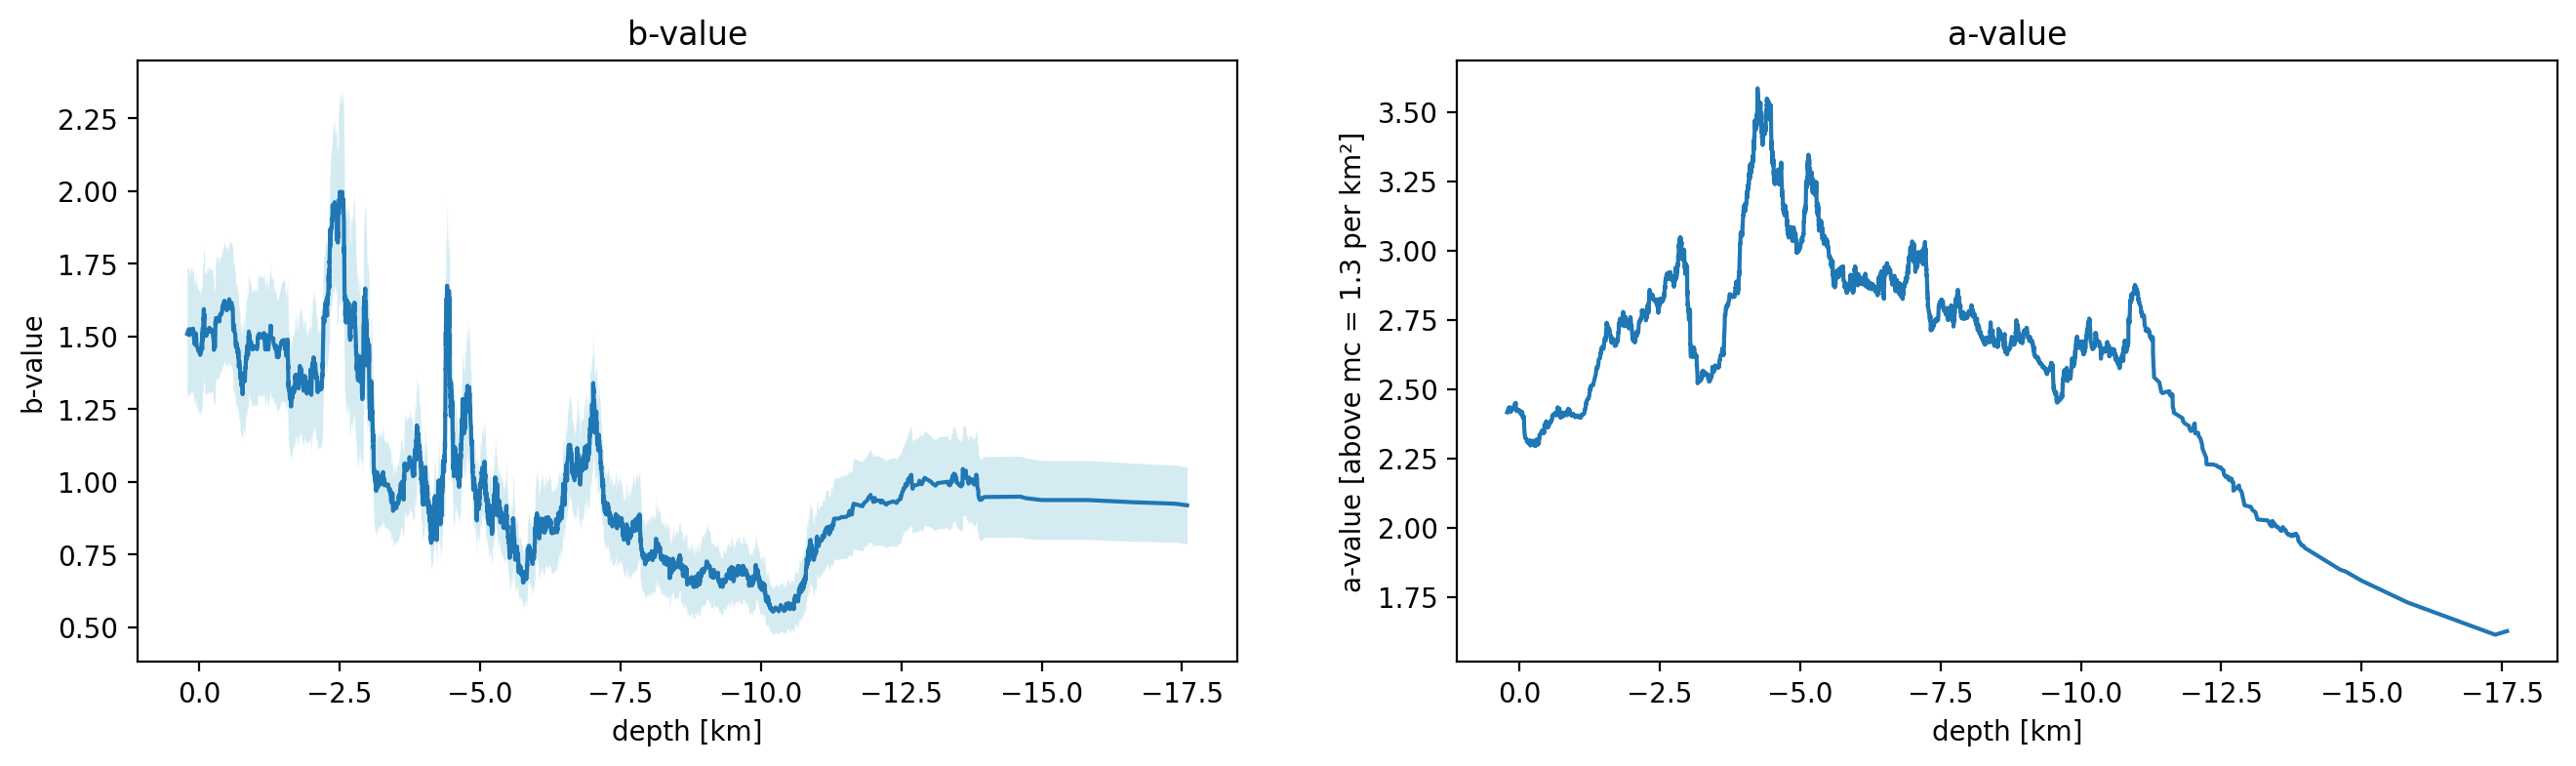

In [26]:
# make two figures next to each other
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

b = b_average[n_max]
a = a_average[n_max]

idx_0 = a == 0
a1 = a[~idx_0]
b1 = b[~idx_0]
t1 = cut_coords[2,:][~idx_0]
std_b1 = std_b[n_max][~idx_0]

# sort
idx = np.argsort(t1)
t1 = t1[idx]

# plot the average b-value map
axs[0].plot(t1, b1)
axs[0].fill_between(t1, b1-2*std_b1, b1+2*std_b1, color='lightblue', alpha=0.5, lw=0)
# plot the average a-value map
axs[1].plot(t1, a1)

axs[0].set_ylabel('b-value')
axs[1].set_ylabel('a-value [above mc = 1.3 per km²]')
axs[0].set_xlabel('depth [km]')
axs[1].set_xlabel('depth [km]')

# flip x axis
axs[0].invert_xaxis()
axs[1].invert_xaxis()
axs[0].title.set_text('b-value')
axs[1].title.set_text('a-value')

In [39]:
max(cut_depths)-min(cut_depths)

np.float64(17.631)

In [30]:
n_m = np.array(np.arange(40, 400, 5))
n_points = np.round(len(cut_mags)/ n_m)
n_points = np.unique(n_points).astype(int)

mac, mu_mac, std_mac, b_average, std_b, mac_a, mu_mac_a, std_mac_a, a_average, n_m  = get_MAC_vs_npoints_1D(cut_coords[0,:], cut_mags, delta_m, mc, cut_times, n_points, n=1000, b_method = 'positive', partitioning = 'constant_idx',scaling_factor=max(cut_depths)-min(cut_depths), image_tech='center')

Processing: 100%|██████████| 53/53 [00:57<00:00,  1.09s/it]


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_40527/2095599357.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(n_m, mu_mac, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


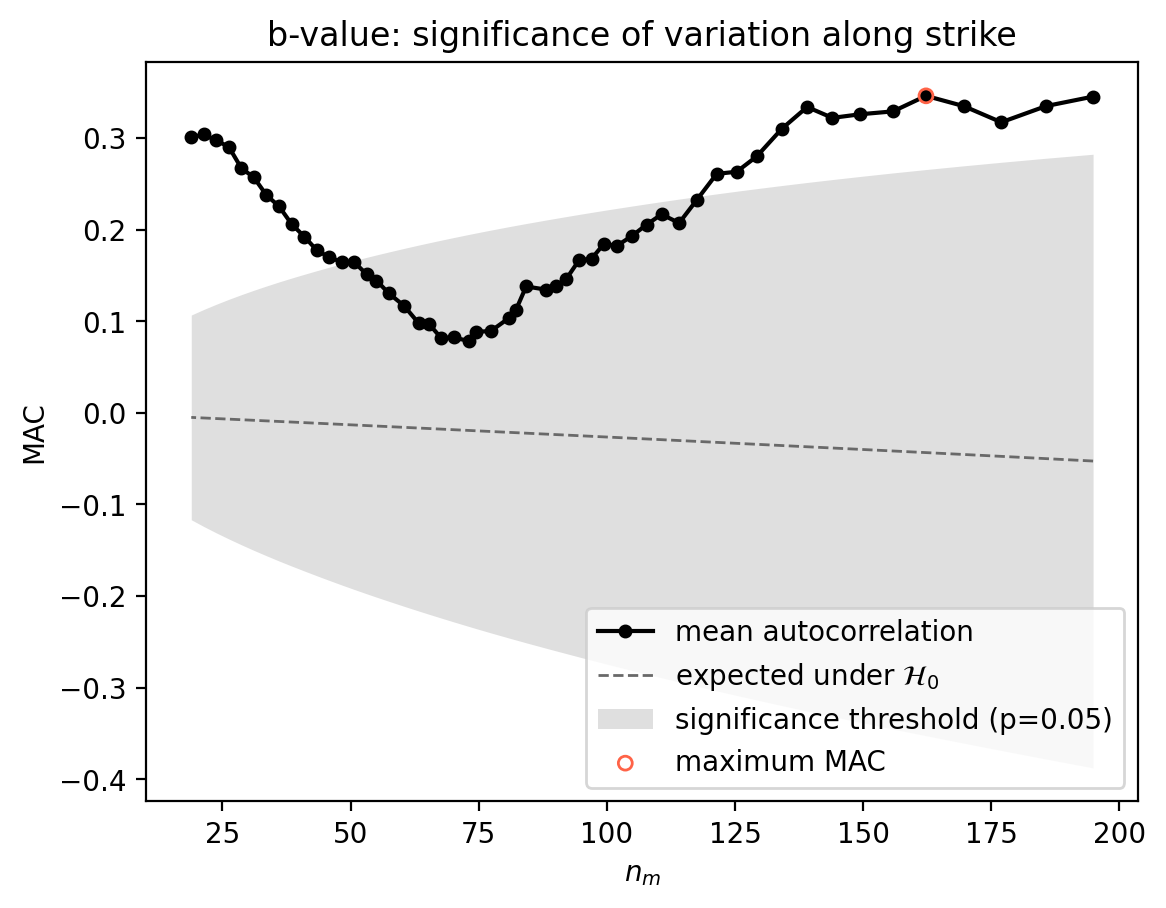

In [31]:
ax = plt.subplots()[1]

ax.plot(n_m, mac, color='k', label='mean autocorrelation', marker='o', markersize=4)    
ax.plot(n_m, mu_mac, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
ax.fill_between(n_m, mu_mac - 1.96 * std_mac, mu_mac + 1.96 * std_mac, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

n_max = np.argmax(mac)
plt.scatter(n_m[n_max], mac[n_max], s=25, zorder=100, facecolor='none', edgecolor='tomato', label='maximum MAC')

ax.legend()
ax.set_xlabel('$n_m$')
ax.set_ylabel('MAC')
ax.title.set_text('b-value: significance of variation along strike')

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_40527/1705556241.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(n_m, mu_mac_a, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


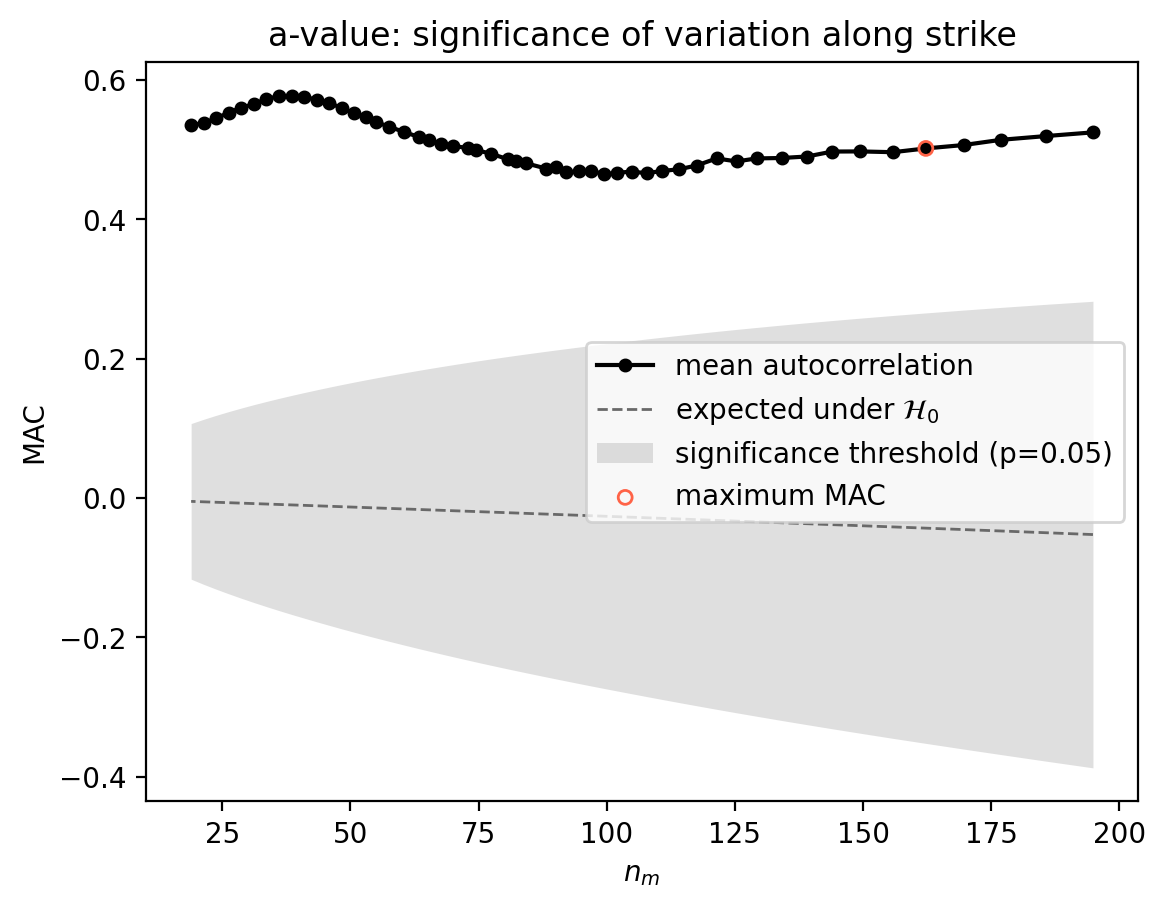

In [32]:
ax = plt.subplots()[1]

ax.plot(n_m, mac_a, color='k', label='mean autocorrelation', marker='o', markersize=4)    
ax.plot(n_m, mu_mac_a, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
ax.fill_between(n_m, mu_mac_a - 1.96 * std_mac_a, mu_mac_a + 1.96 * std_mac_a, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

plt.scatter(n_m[n_max], mac_a[n_max], s=25, zorder=100, facecolor='none', edgecolor='tomato', label='maximum MAC')

ax.legend()
ax.set_xlabel('$n_m$')
ax.set_ylabel('MAC')
ax.title.set_text('a-value: significance of variation along strike')

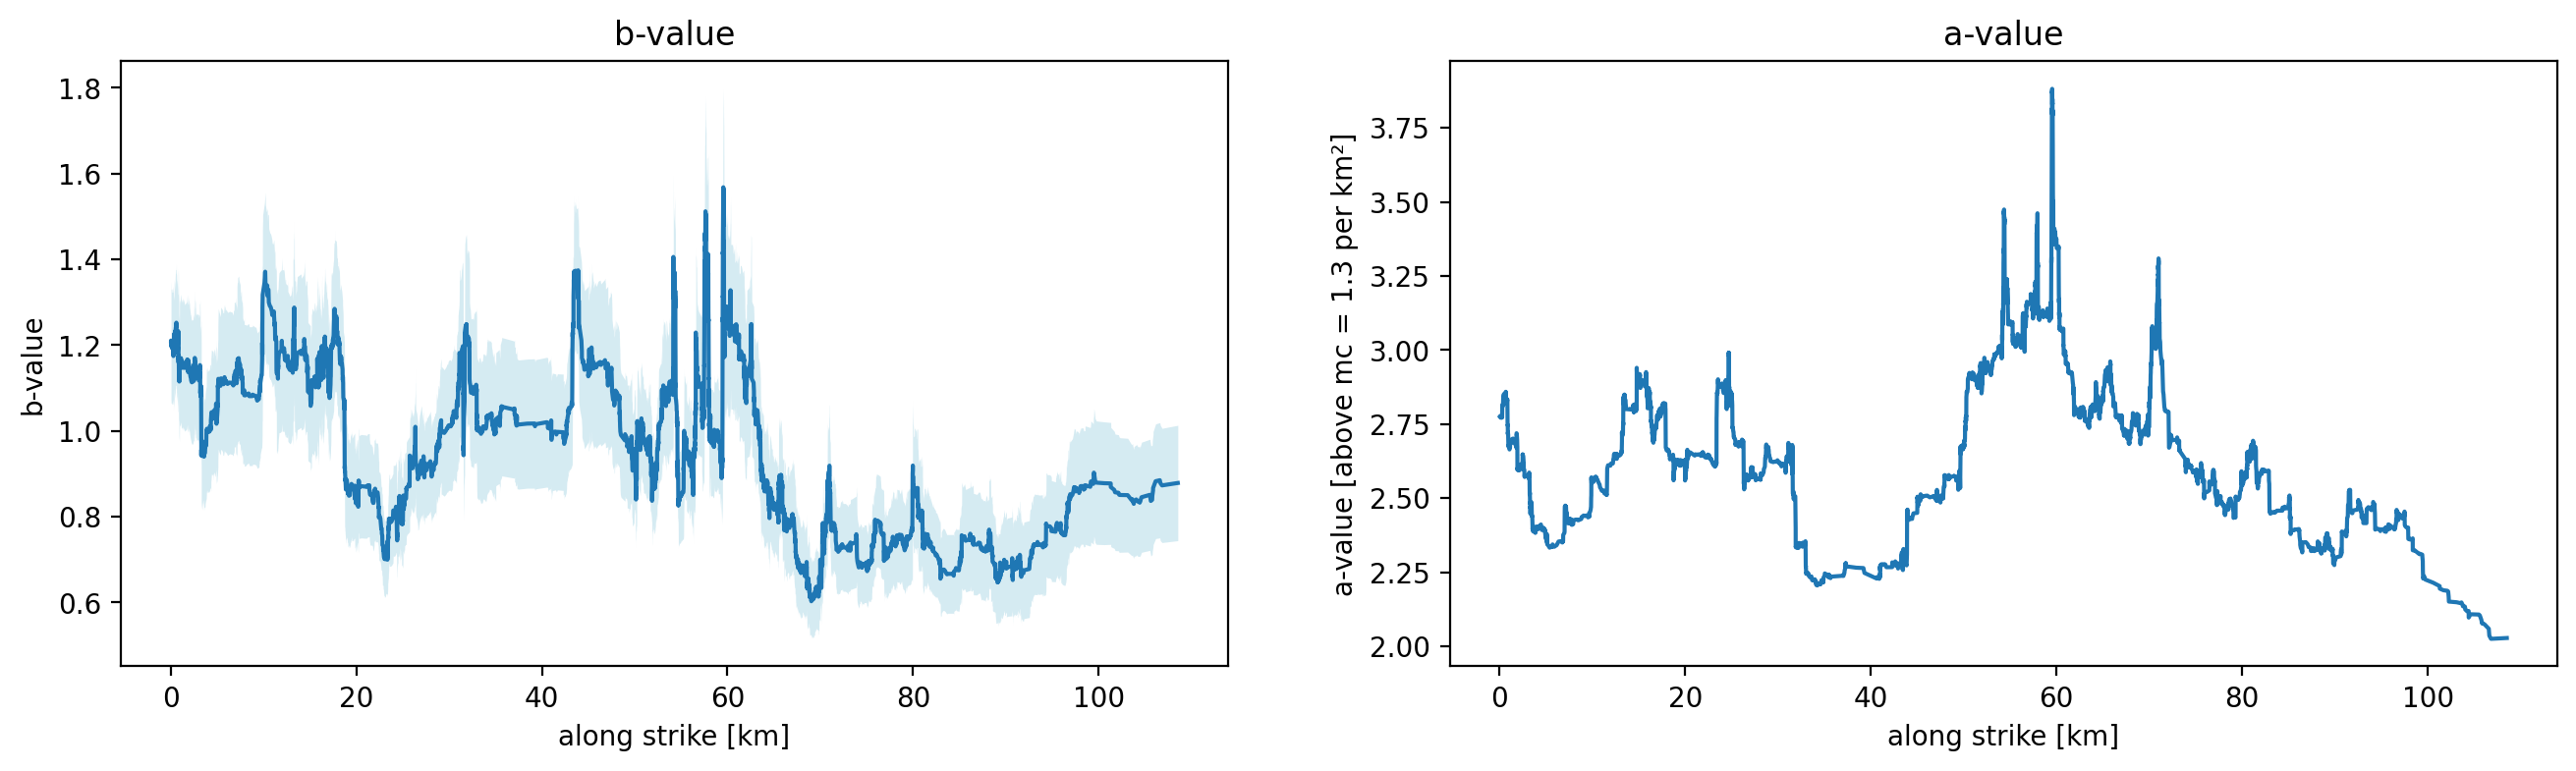

In [33]:
# make two figures next to each other
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

b = b_average[n_max]
a = a_average[n_max]

idx_0 = a == 0
a2 = a[~idx_0]
b2 = b[~idx_0]
t2 = cut_coords[0,:][~idx_0]
std_b2 = std_b[n_max][~idx_0]

# sort
idx = np.argsort(t2)
t2 = t2[idx]

# plot the average b-value map
axs[0].plot(t2, b2)
axs[0].fill_between(t2, b2-2*std_b2, b2+2*std_b2, color='lightblue', alpha=0.5, lw=0)
# plot the average a-value map
axs[1].plot(t2, a2)

axs[0].set_ylabel('b-value')
axs[1].set_ylabel('a-value [above mc = 1.3 per km]')
axs[0].set_xlabel('along strike [km]')
axs[1].set_xlabel('along strike [km]')
axs[0].title.set_text('b-value')
axs[1].title.set_text('a-value')

In [69]:
n_m = np.array(np.arange(30, 420, 10))
n_points = np.round(len(cut_mags)/ n_m)
n_points = np.unique(n_points).astype(int)

mac, mu_mac, std_mac, b_average, std_b, mac_a, mu_mac_a, std_mac_a, a_average, n_m  = get_MAC_vs_npoints_1D(cut_times, cut_mags, delta_m, mc, cut_times, n_points, n=1000, b_method = 'positive', partitioning = 'constant_idx',scaling_factor=max(cut_depths)-min(cut_depths), image_tech='right')


Processing: 100%|██████████| 36/36 [00:48<00:00,  1.36s/it]


<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_40527/2332881121.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(n_m, mu_mac, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


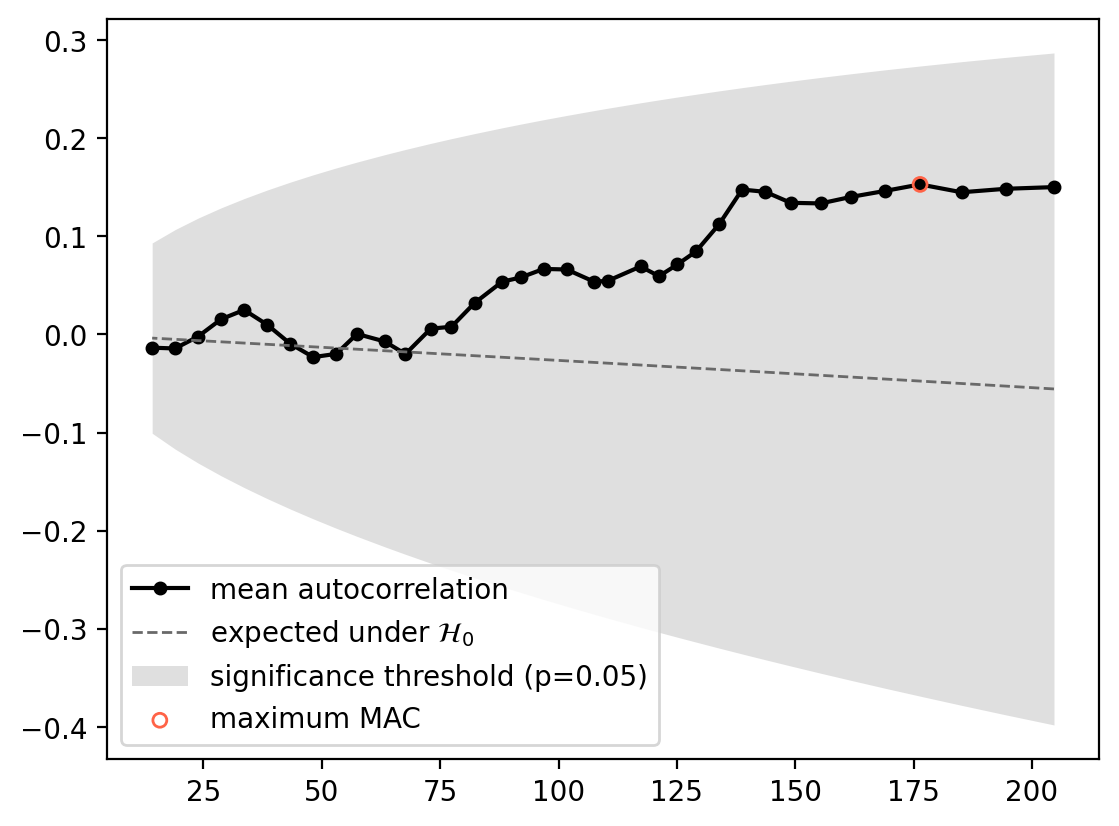

In [70]:
ax = plt.subplots()[1]

ax.plot(n_m, mac, color='k', label='mean autocorrelation', marker='o', markersize=4)    
ax.plot(n_m, mu_mac, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
ax.fill_between(n_m, mu_mac - 1.96 * std_mac, mu_mac + 1.96 * std_mac, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

n_max = np.argmax(mac)
plt.scatter(n_m[n_max], mac[n_max], s=25, zorder=100, facecolor='none', edgecolor='tomato', label='maximum MAC')

ax.legend()

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/var/folders/2_/2txg_9093x37rv1ls3774xkc0000gn/T/ipykernel_40527/1839406034.py:4: SyntaxWarning: invalid escape sequence '\m'
  ax.plot(n_m, mu_mac_a, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)


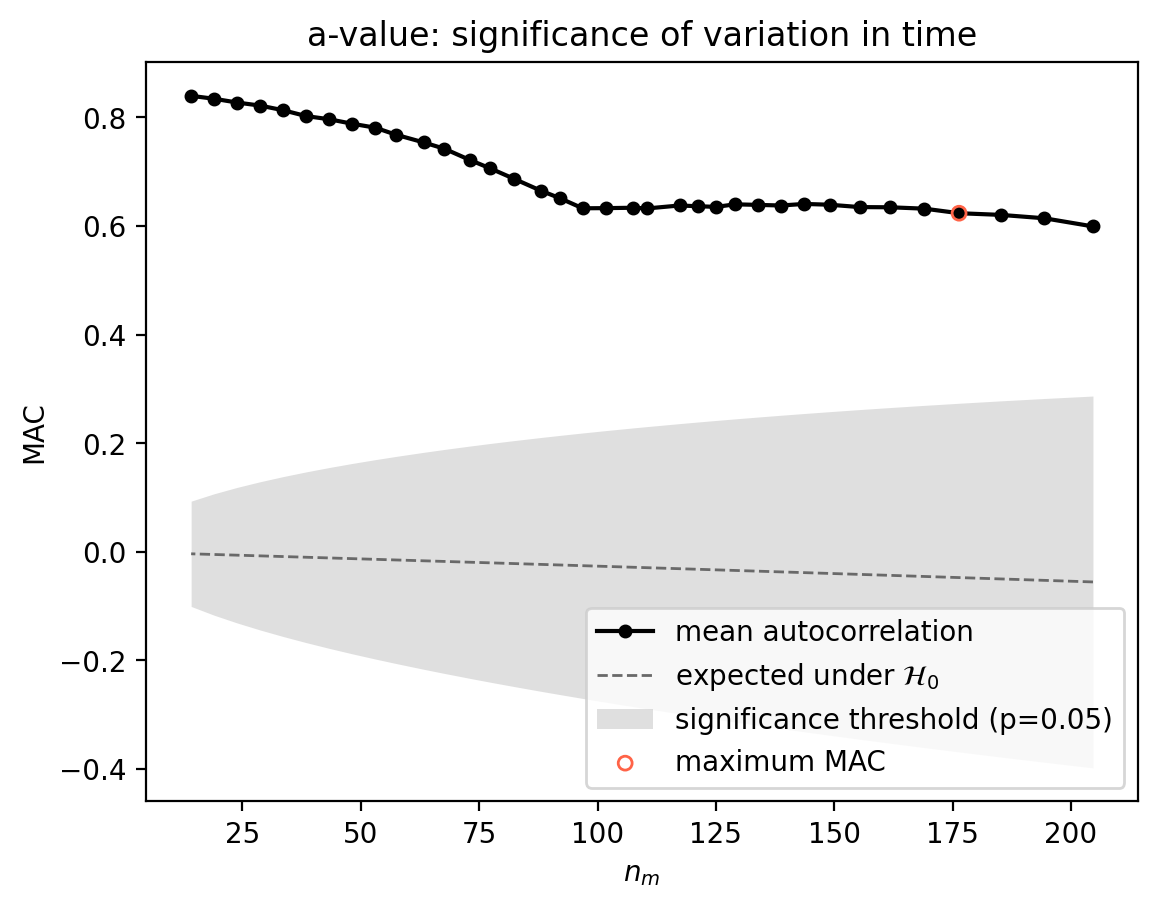

In [71]:
ax = plt.subplots()[1]

ax.plot(n_m, mac_a, color='k', label='mean autocorrelation', marker='o', markersize=4)    
ax.plot(n_m, mu_mac_a, color='dimgrey', label='expected under $\mathcal{H}_0$', linestyle='--', lw=1)
ax.fill_between(n_m, mu_mac_a - 1.96 * std_mac_a, mu_mac_a + 1.96 * std_mac_a, alpha=0.5, color='silver', label='significance threshold (p=0.05)', lw=0)

plt.scatter(n_m[n_max], mac_a[n_max], s=25, zorder=100, facecolor='none', edgecolor='tomato', label='maximum MAC')

ax.legend()
ax.set_xlabel('$n_m$')
ax.set_ylabel('MAC')
ax.title.set_text('a-value: significance of variation in time')

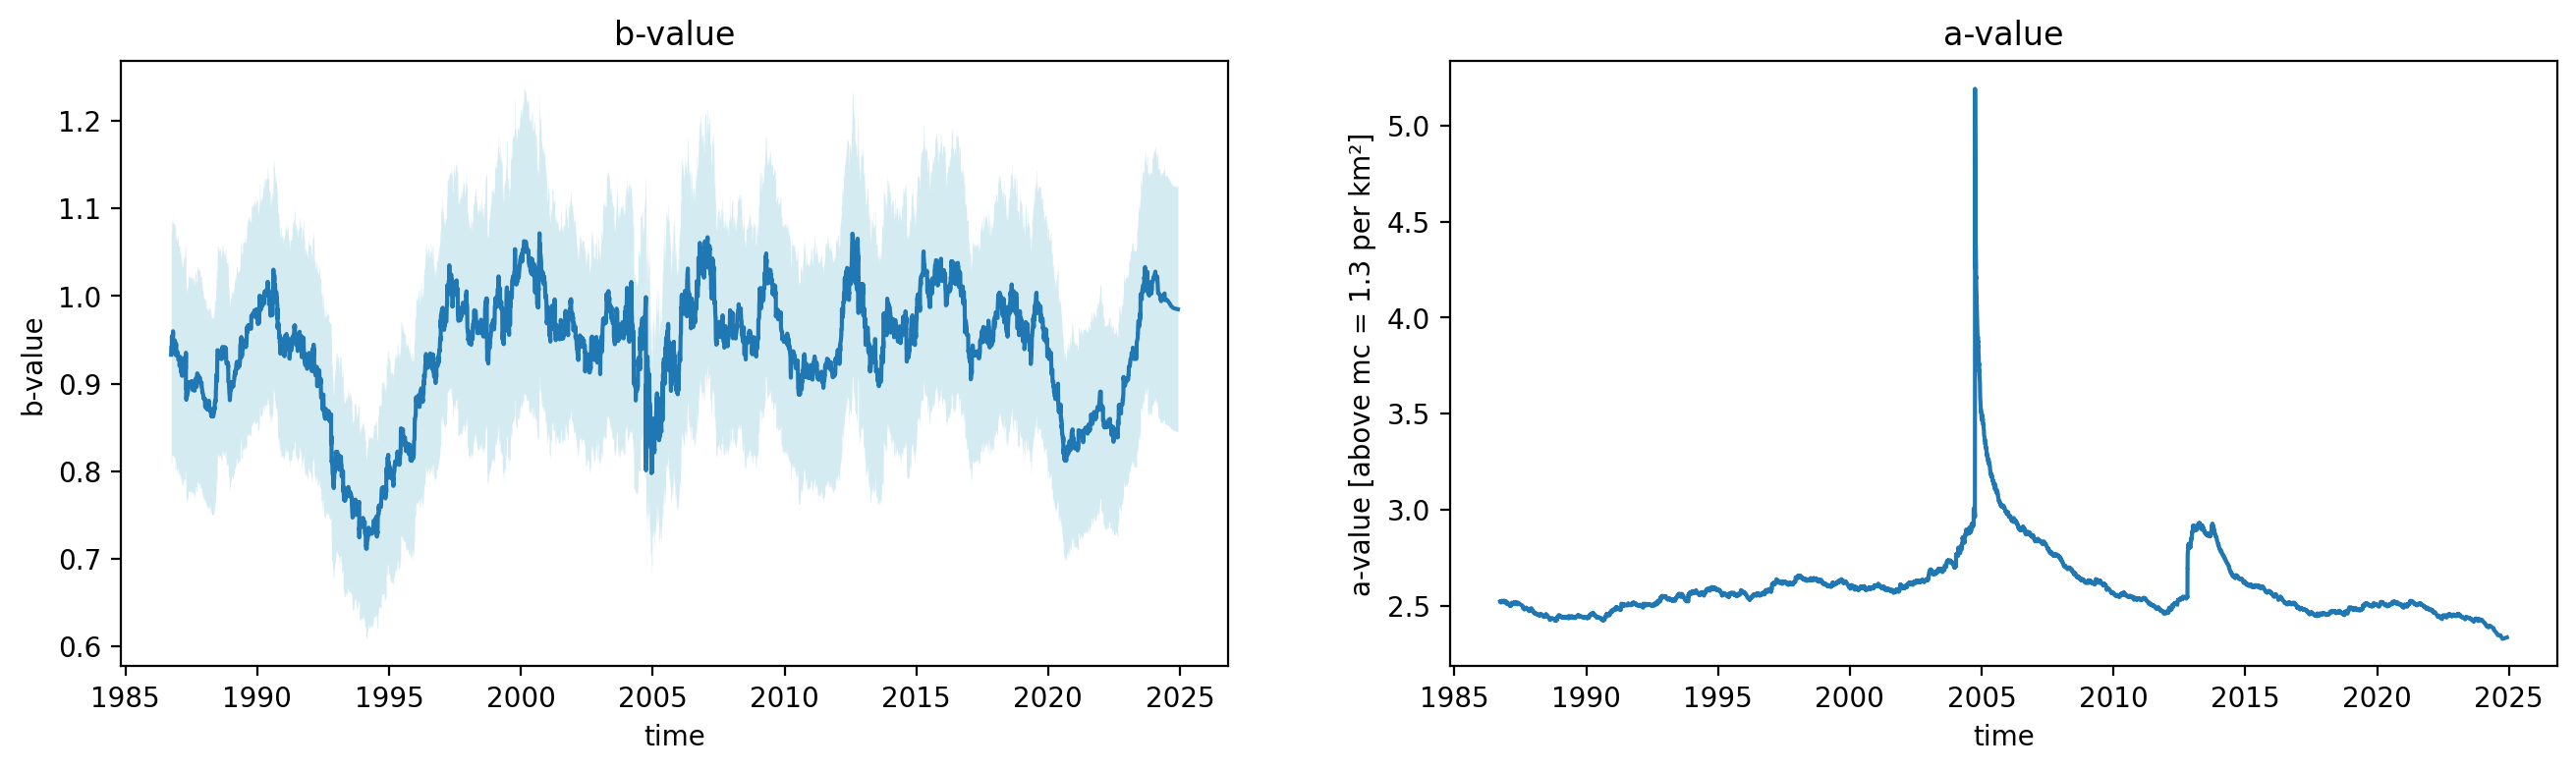

In [72]:
# make two figures next to each other
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

b = b_average[n_max]
a = a_average[n_max]

idx_0 = a == 0
a3 = a[~idx_0]
b3 = b[~idx_0]
t3 = cut_times[~idx_0]
std_b3 = std_b[n_max][~idx_0]

# plot the average b-value map
axs[0].plot(t3, b3)
axs[0].fill_between(t3, b3-2*std_b3, b3+2*std_b3, color='lightblue', alpha=0.5, lw=0)
# plot the average a-value map
axs[1].plot(t3, a3)

axs[0].set_ylabel('b-value')
axs[1].set_ylabel('a-value [above mc = 1.3 per km²]')
axs[0].set_xlabel('time')
axs[1].set_xlabel('time')
axs[0].title.set_text('b-value')
axs[1].title.set_text('a-value')